In [113]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [42]:
train_df = pd.read_csv("train.csv")
train_df.head(10)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
5,004AC288D833,"Dear Principal,\r\n\r\nOur school should have ...",3.5,4.0,4.0,3.5,3.5,4.0
6,005661280443,Imagine if you could prove other people that y...,3.5,4.0,3.5,3.5,4.0,4.0
7,008DDDDD8E8D,I think it's a good idea for the estudnets to ...,2.5,2.5,2.5,2.5,2.5,2.0
8,009BCCC61C2A,positive attitude is the key to success. I agr...,3.0,3.0,3.5,3.5,3.0,3.0
9,009F4E9310CB,Asking more than one person for and advice hel...,3.0,3.0,3.5,2.5,3.0,2.5


In [43]:
len(train_df)

3911

In [98]:
sample_sub = pd.read_csv("sample_submission.csv")
sample_sub.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [88]:
print(train_df.full_text[0])

I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.

The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.

most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take a

Text(0.5, 1.0, 'conventions')

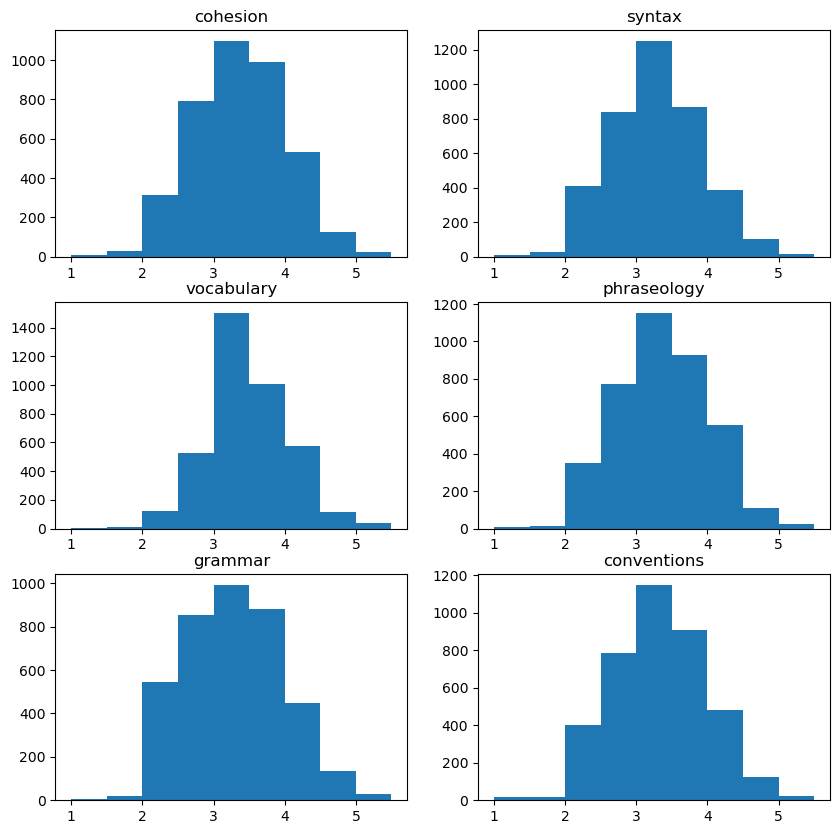

In [77]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 10)
bins = torch.arange(1, 6, 0.5)

axs[0, 0].hist(train_df.cohesion.values, bins=bins);
axs[0, 0].set_title('cohesion')
axs[0, 1].hist(train_df.syntax.values, bins=bins);
axs[0, 1].set_title('syntax')
axs[1, 0].hist(train_df.vocabulary.values, bins=bins);
axs[1, 0].set_title('vocabulary')
axs[1, 1].hist(train_df.phraseology, bins=bins);
axs[1, 1].set_title('phraseology')
axs[2, 0].hist(train_df.grammar, bins=bins);
axs[2, 0].set_title('grammar')
axs[2, 1].hist(train_df.conventions, bins=bins);
axs[2, 1].set_title('conventions')

In [85]:
train_df.loc[train_df['grammar'] == 1].head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
514,2716F5E20A4F,"The students be required to take music ,drama ...",1.5,1.0,1.5,1.0,1.0,1.5
952,48EA282A4EAF,some student offer distance learning as an opt...,1.0,1.0,1.0,1.0,1.0,1.0
1528,75A20F93C2C4,i like to work with a group a cash if you work...,1.5,1.5,1.5,1.0,1.0,1.0
1540,767533E12569,he is a good because they are the prescient an...,1.0,1.0,1.0,1.0,1.0,1.0
1554,776FBF88E6FF,Welll its going to be ah good beefit but in th...,1.5,1.5,2.0,2.0,1.0,1.0


In [81]:
print(train_df.full_text[514])

The students be required to take music ,drama ,or an art class. is important all the student to this to class because is a element important for all students., also is part the education and many people, I like for the music and art. other like drama . The people dont not like, but is necessary to take this class because is big formation very important and can't be graduated learning somethings .

The class the music to help a relax , and class the drama is a part of fundamental , the class of art is more creatividad leaning some different thing ,.

The art is very good class because used to creatividad and used to things and of head practice the things.

music the arrangement of sounds made by music instruments or voice, the class the drama is example when exposed a history

I make the paper for author is draticamatica and when leaning a book after has why explicalor about the history of book.

all the class is very important because learning many things .

drama and art of the same c

In [84]:
train_df.loc[train_df['cohesion'] == 5].head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
104,07CE77EA56C5,Students work hard there is no arguing that. T...,5.0,5.0,5.0,5.0,4.5,4.5
258,12E3D52345C6,Technology has always acted as a compelling an...,5.0,5.0,5.0,5.0,4.5,5.0
478,244973AE9715,Many people are kind and do parts in helping o...,5.0,4.5,5.0,4.5,5.0,4.0
668,33DEFCDAD05F,Technology has made a positive impact in our l...,5.0,4.0,4.0,4.5,4.0,4.0
675,3438C0C5ACEA,I oppose to extending the school day to one an...,5.0,4.0,4.0,4.5,5.0,4.5


In [92]:
train_df.corr(numeric_only=True)

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


In [107]:
len(tokenizer.get_vocab())

30522

In [122]:
from transformers import BertModel
bert = BertModel.from_pretrained("bert-base-uncased")
bert_embed = bert.embeddings.word_embeddings
bert_embed

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30522, 768, padding_idx=0)

## Model

In [181]:
from transformers import BertModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert_embed = bert.embeddings.word_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [176]:
hidden_size = 512

class LSTM(nn.Module):
    
    def __init__(self, emb):
        super().__init__()
        vocab_size, embed_size = emb.weight.shape
        
        self.emb = emb
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        emb = self.emb(x)
        seq, (hidden, _) = self.lstm(emb)
        y = self.linear(hidden)
        return y

In [180]:
tokens = tokenizer.tokenize(train_df.full_text[12])
ids = tokenizer.convert_tokens_to_ids(tokens)
X = torch.tensor([ids]) # (B, L)

model = LSTM(bert_embed)
model(X)

tensor([[[0.0067]]], grad_fn=<ViewBackward0>)